In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pickle
np.set_printoptions(threshold=np.inf)

In [2]:
def C(x):
    if(x):
        return 1
    return 1./np.sqrt(2)

def DCT_1d(input):

    dct_1d = np.zeros(input.shape)
    N      = input.shape[0]
    for u in range(N):
        sum = 0
        for x in range(N):
            sum += input[x] * np.cos((2*x+1) * u * np.pi/(2*N))
        dct_1d[u] = sum * C(u) * np.sqrt(2/N)

    return dct_1d


def IDCT_1d(input):
    idct_1d = np.zeros(input.shape)
    N = input.shape[0]
    for x in range(N):
        sum = 0
        for u in range(N):
            sum += C(u) * input[u] * np.cos((2*x+1) * u * np.pi/(2*N))
        idct_1d[x] = sum * np.sqrt(2/N)

    return idct_1d

def DCT(img):
    r = img.shape[0]
    dct = np.zeros(img.shape)
    for i in tqdm(range(r), desc="dct_1d_x"):
        dct[i,:] = DCT_1d( img[i,:])

    for i in tqdm(range(r), desc="dct_1d_y"):
        dct[:,i] = DCT_1d( dct[:,i])

    np.save('dct', dct)
    return dct

def IDCT(img):
    r = img.shape[0]
    idct = np.zeros(img.shape)
    for i in tqdm(range(r), desc="idct_1d_y"):
        idct[:,i] = IDCT_1d(img[:,i])
    for i in tqdm(range(r), desc="idct_1d_x"):
        idct[i,:] = IDCT_1d(  idct[i,:])

    return idct

In [3]:
def encode(dct, i_offset = 0, j_offset = 0):
    up    = 1
    i     = 0
    j     = 0
    m     = 8
    n     = 8
    count = 0
    
    DC = 0
    AC = []

    s = (dct.max()-dct.min())/(2**8-1)

    dct = (dct/s).astype(int)

    turned = False
    d      = [ [ 1, -1 ], [ -1, 1 ] ]
    corner = [ [ 1, 0, 0, 1 ], [ 0, 1, 1, 0 ] ]
    while (i < m and j < n):
        
        if(i ==  0 and j == 0):
            DC = dct[i+i_offset][j+j_offset]
        else:
            current = dct[i+i_offset][j+j_offset]
            if(current):
                AC.append([current, count])
                count = 0
            else:
                count += 1

        if (i == 0 or j == 0 or i == m - 1 or j == n - 1) :
            if (not turned):
                k = 2 * (int(up * (j / (n - 1))) | int((1 - up) * (i / (m - 1))))
                i += corner[up][k]
                j += corner[up][k + 1]
                turned = True
                up = 1 - up
                continue
            else:
                turned = False

        i += d[up][0]
        j += d[up][1]

    return DC, AC, s
    

In [4]:
def decode(dc, ac, s):

    up    = 1
    i     = 0
    j     = 0
    m     = 8
    n     = 8
    count = 0

    recon_dct = np.zeros((8,8))

    turned = False
    d      = [ [ 1, -1 ], [ -1, 1 ] ]
    corner = [ [ 1, 0, 0, 1 ], [ 0, 1, 1, 0 ] ]
    while (i < m and j < n):
        
        if(i ==  0 and j == 0):
            recon_dct[i][j] = dc
        else:
            if not ac:
                return recon_dct
            elif count == 0:
                code = ac.pop(0)
                element, count = code[0], code[1]
                recon_dct[i][j] = element
            else:
                count -= 1

        if (i == 0 or j == 0 or i == m - 1 or j == n - 1) :
            if (not turned):
                k = 2 * (int(up * (j / (n - 1))) | int((1 - up) * (i / (m - 1))))
                i += corner[up][k]
                j += corner[up][k + 1]
                turned = True
                up = 1 - up
                continue
            else:
                turned = False

        i += d[up][0]
        j += d[up][1]


    recon_dct *= s 

    return recon_dct
    

In [5]:
# load image
r = 512
image = np.asarray(Image.open('lena.png').convert('L').resize((int(r), int(r))))

In [6]:
# DCT
dct_1d = DCT(image)


dct_1d_y: 100%|██████████| 512/512 [01:57<00:00,  4.35it/s]


In [7]:
# Encode
DC = []
AC = []
S  = []
for i in range(0, r, 8):
    for j in range(0, r, 8):
        dc, ac, s = encode(dct_1d[i:i+8,j:j+8])
        DC.append(dc)
        AC.append(ac)
        S.append(s)

DC = np.array(DC)
dc_s = (DC.max()-DC.min())/(2**16-1)
DC = (DC/s).astype(int).tolist()

out = [DC, dc_s, AC, S]
with open("Encoded_img.bin", "wb") as fp:
    pickle.dump(out, fp)

In [8]:
# Decode
with open("Encoded_img.bin", "rb") as fp:
    bin = pickle.load(fp)

DC   = bin[0]
dc_s = bin[1]
DC   = np.array(DC)
DC   = (DC*dc_s).tolist()

AC   = bin[2]
S    = bin[3]
count = 0
recon = np.zeros(image.shape)
for i in range(0, r, 8):
    for j in range(0, r, 8):
        recon[i:i+8,j:j+8] = decode(DC[count], AC[count], S[count])
        count += 1

recon = recon.astype(int)
recon
idct_1d = IDCT(recon)

idct_1d_x: 100%|██████████| 512/512 [03:05<00:00,  2.76it/s]


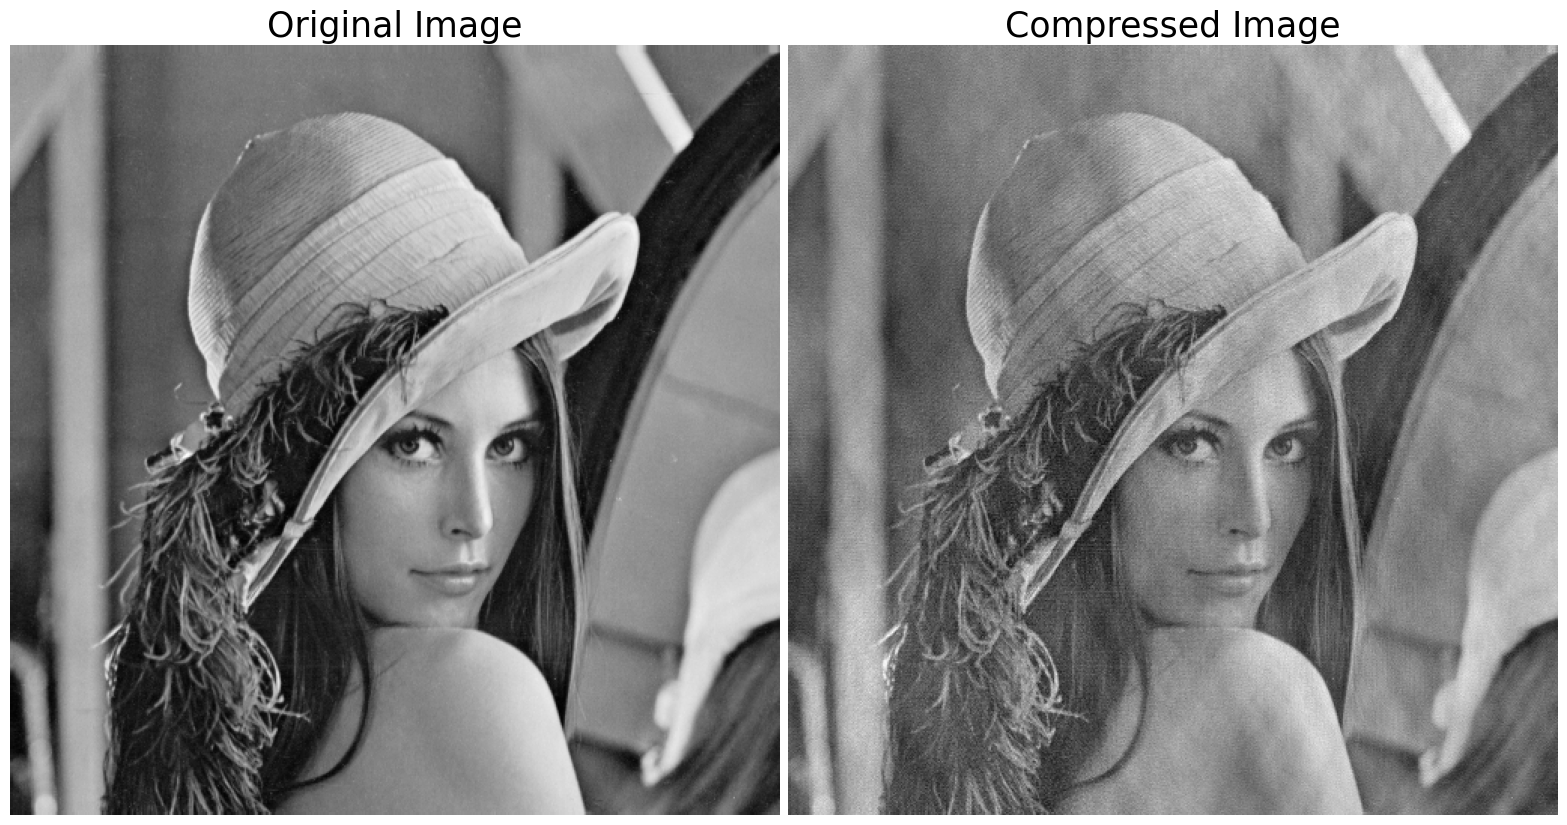

In [9]:
# plot
plt.figure(num='astronaut',figsize=(30,30))

plt.subplot(1,3,1)
plt.title('Original Image',fontsize = 25)
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Compressed Image',fontsize = 25) 
plt.imshow(idct_1d, cmap='gray')
plt.axis('off')

plt.subplots_adjust(wspace=0.01)